ARIMA MODEL NO DECOMP OR DIFFERNCING PRIOR TO RUNNING

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
#filepath
NYT_file="Potential Data Sources/NYT- Cty Cases Deaths Thru Oct2/us-counties.csv"

#read dataset
NYT=pd.read_csv(NYT_file, parse_dates=['date'])

# limit dataset to texas
Texas=NYT.loc[NYT['state']=='Texas'].dropna(how='any', axis=0)
Texas['county']=Texas['county'].map(str)+' County'
Texas2=Texas.drop(['fips', 'state'], axis=1)

### pick a county
CtyName='El Paso County'
CountyChoice=Texas2.loc[Texas2['county']==CtyName].set_index('date')
CountyChoice2=CountyChoice.drop('county', axis=1)

# CountyChoice2=Texas2
CountyChoice2

,cases,deaths
date,,
2020-03-13,1,0
2020-03-14,1,0
2020-03-15,2,0
2020-03-16,2,0
2020-03-17,2,0
...,...,...
2020-09-29,24170,523
2020-09-30,24446,526
2020-10-01,24666,528


In [3]:
#param analysis for ARIMA model:
data=CountyChoice2['cases']

# Split data into train / test sets 
# Isolate only the transformed data into a dataframe for the model

# split test train 
end_train=pd.to_datetime('2020-07-31')
start_test=pd.to_datetime('2020-08-01')
train=data[:end_train]
test=data[start_test:]
print(train.shape, test.shape)

(141,) (64,)


In [4]:
# Import the library 
from pmdarima import auto_arima 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(train, start_p = 1, start_q = 1, 
                          max_p = 10, max_q = 30, m = 2, #monthly
                          start_P = 0, seasonal = True, 
                          stationary=True,
                          trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 
x=stepwise_fit.get_params()
    
# override Q parameter if 0 to 1
so=x['seasonal_order']
so_slice1=so[ :2]
so_slice2=so[3:]
if so[2]==0 & so[3]!= 0:
    so=so_slice1+ (1,) +so_slice2

print(x)
print(so)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=1646.999, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=2747.400, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=2828.559, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1724.705, Time=0.15 sec
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=1555.290, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=1585.698, Time=0.21 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1560.739, Time=0.39 sec
 ARIMA(1,0,1)(1,0,2)[2] intercept   : AIC=1564.168, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[2] intercept   : AIC=1611.177, Time=0.29 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=1566.718, Time=0.29 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=1555.200, T

In [5]:
# Fit a SARIMAX(1,0,1)(2,0,0,12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,
                order = (x['order']),
                seasonal_order =(so),
                initialization='approximate_diffuse')
  
result = model.fit() 
result.summary() 

C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  cases   No. Observations:                  141
Model:             SARIMAX(1, 0, 0)x(2, 0, [1, 2], 2)   Log Likelihood                -777.695
Date:                                Tue, 20 Oct 2020   AIC                           1567.389
Time:                                        00:08:51   BIC                           1585.082
Sample:                                    03-13-2020   HQIC                          1574.579
                                         - 07-31-2020                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.050     20.066      0.000       0.902       1.097
ar.S.L2        1.6625      0.216      7.701      0.000       1.239       2.086
ar.S.L4       -0.6672      0.217     -3.070      0.002      -1.093      -0.241
ma.S.L2       -1.3833      0.194     -7.133      0.000      -1.763      -1.003
ma.S.L4        0.6030      0.110      5.484      0.000       0.388       0.819
sigma2      2942.6157    298.748      9.850      0.000    2357.081    3528.150
===================================================================================
Ljung-Box (Q):                      102.14   Jarque-Bera (JB):                16.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.34   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

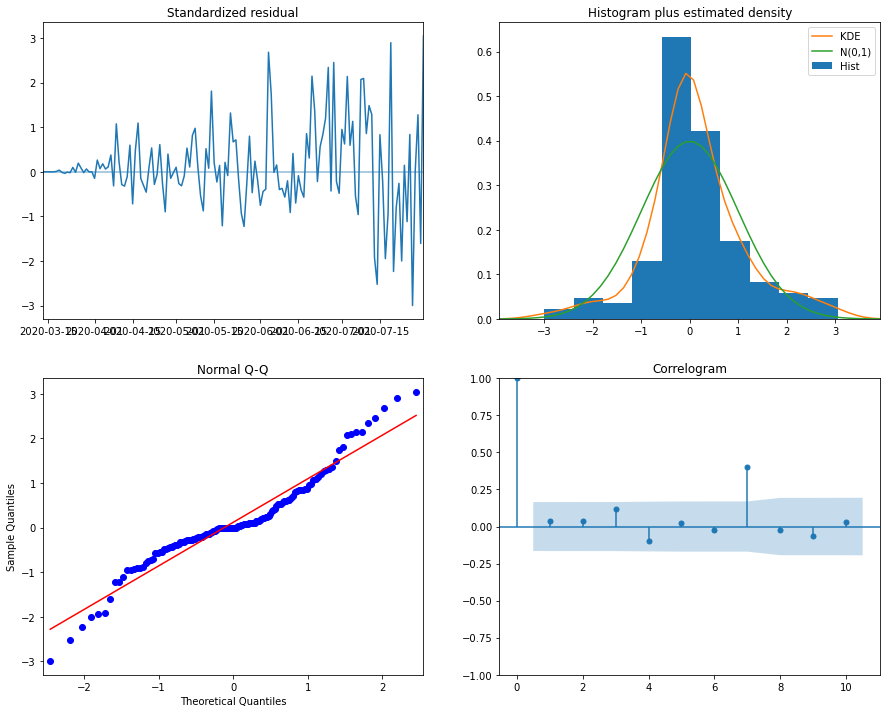

In [6]:
result.plot_diagnostics(figsize=(15,12));

<AxesSubplot:xlabel='date'>

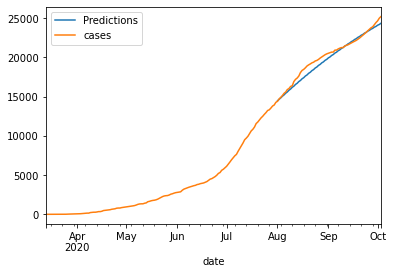

In [7]:
# compare test train
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end).rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
data.plot(legend = True)

In [8]:
predictions

2020-08-01    14467.025102
2020-08-02    14670.270944
2020-08-03    14847.157325
2020-08-04    15059.842811
2020-08-05    15226.399885
                  ...     
2020-09-29    23863.230546
2020-09-30    23958.013242
2020-10-01    24110.409234
2020-10-02    24203.608946
2020-10-03    24353.588673
Freq: D, Name: Predictions, Length: 64, dtype: float64

In [9]:
#  get results for full dataset:
end=pd.to_datetime('2020-10-03')
start=pd.to_datetime('2020-04-01')
formodel=data[start:end]

#   cases_best_training_model for full data
stepwise_fit_full = auto_arima(formodel, start_p = 1, start_q = 1, 
                                max_p = 10, max_q = 30, m = 2,
                                start_P = 0, seasonal = True, 
                                stationary=True,
                                trace = True, 
                                error_action ='ignore',   # we don't want to know if an order does not work 
                                suppress_warnings = True,  # we don't want convergence warnings 
                                stepwise = True)           # set to stepwise

# pull out the parameters of the best model for this county
x_full=stepwise_fit_full.get_params()
    
# override Q parameter if 0 to 1
so_full=x_full['seasonal_order']
so_full_slice1=so_full[ :2]
so_full_slice2=so_full[3:]
if so_full[2]==0 & so_full[3]!= 0:
    so_full=so_full_slice1+ (1,) +so_full_slice2

print(x_full)
print(so_full)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=3895.008, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=4049.679, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=3819.832, Time=0.04 sec
 ARIMA(0,0,0)(2,0,0)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(2,0,1)[2] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=2178.660, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=2356.418, Time=0.18 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=2132.065, Time=0.35 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=2187.584, Time=0.39 sec
 ARIMA(1,0,

In [10]:
# runs model with best fit ARIMA params
full_model = SARIMAX(formodel,
                order = (x_full['order']),
                seasonal_order =(x_full['seasonal_order']),
                initialization='approximate_diffuse')

full_result = full_model.fit()

full_result.summary()

C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\track\anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              cases   No. Observations:                  186
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 2)   Log Likelihood               -1065.568
Date:                            Tue, 20 Oct 2020   AIC                           2141.135
Time:                                    00:08:59   BIC                           2157.264
Sample:                                04-01-2020   HQIC                          2147.671
                                     - 10-03-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.039     25.900      0.000       0.924       1.076
ma.L1         -0.0584      0.064     -0.913      0.361      -0.184       0.067
ar.S.L2        0.4786      0.075      6.353      0.000       0.331       0.626
ar.S.L4        0.5213      0.069      7.587      0.000       0.387       0.656
sigma2      4933.3818    479.941     10.279      0.000    3992.714    5874.050
===================================================================================
Ljung-Box (Q):                       94.83   Jarque-Bera (JB):                 7.21
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               4.91   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# Getting 120 days (a little more than 6 months in business days) for forecasts
SARIMAX_forecast = round(full_result.forecast(steps = 90))

idx = pd.date_range('2020-10-04', '2021-01-01', freq='d')
 
SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
columns=['Date','Forcast Cases']).set_index('Date')


SARIMAX_forecast

,Forcast Cases
Date,
2020-10-04,25511.0
2020-10-05,25725.0
2020-10-06,26044.0
2020-10-07,26254.0
2020-10-08,26566.0
...,...
2020-12-28,47712.0
2020-12-29,48024.0
2020-12-30,48233.0


(18353.0, 18627.0)

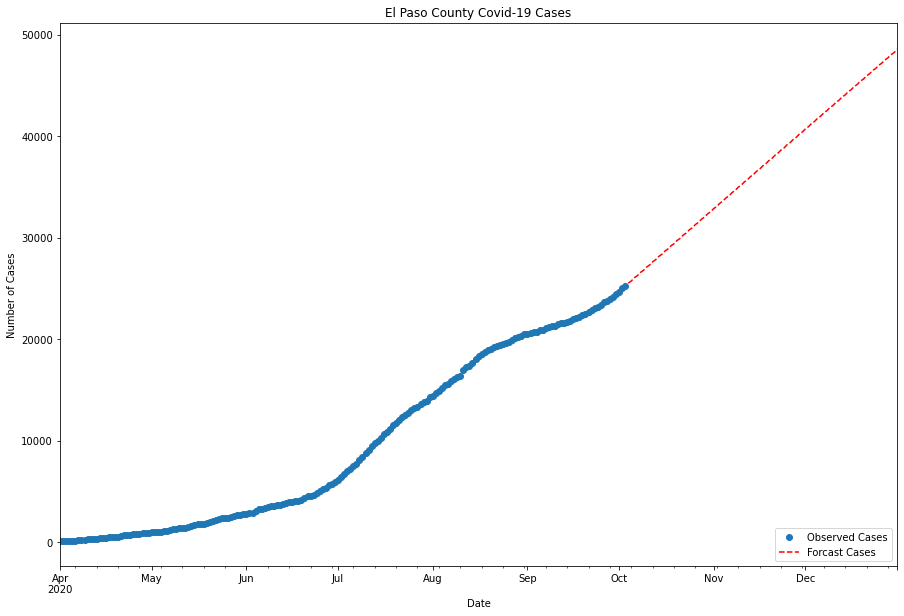

In [12]:
# Graph
fig, ax = plt.subplots(figsize=(15,10))
npre = 4
ax.set(title= f'{CtyName} Covid-19 Cases', xlabel='Date', ylabel='Number of Cases')


# Plot data points
data.loc['2020-04-01':].plot(ax=ax, style='o', label='Observed Cases')

# Plot predictions
SARIMAX_forecast.loc['2020-10-03':].plot(ax=ax, style='r--', label='Sarimax forecast')

# predict.predicted_mean.loc['2020-04-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
# ci = predict_ci.loc['2020-04-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
# predict_dy.predicted_mean.loc['2020-04-01':].plot(ax=ax, style='g', label='Dynamic forecast')
# ci = predict_dy_ci.loc['2020-04-01':]
# ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)


legend = ax.legend(loc='lower right')
ax.set_xlim(np.datetime64('2020-04-01'), np.datetime64('2020-12-31'))